In [ ]:
!pip install bayesian-optimization lightgbm xgboost catboost tensorflow scikit-learn pandas numpy matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 7.9 MB/s eta 0:00:00


## Preview of the data
### Data Size

In [ ]:
import pandas as pd
df = pd.read_csv('credit_card_transactions.csv')

# Get the number of columns and rows
print("Number of Columns:", len(df.columns))
print("Number of Rows:", len(df))

#Preview of the data
df_types = pd.DataFrame(df.dtypes).reset_index()
df_types.columns = ['Feature Name', 'Data Type']
df_types

#Check missing value
missing_counts = df.isnull().sum()
missing_counts_df = pd.DataFrame(missing_counts).reset_index()
missing_counts_df.columns = ['Feature', 'Missing Value Count']
missing_counts_df

Number of Columns: 24
Number of Rows: 1296675


LightGBM/XGboost + SMOTE

Dataset loaded successfully with shape: (1296675, 24)

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296675 entries, 0 to 1296674
Data columns (total 24 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   Unnamed: 0             1296675 non-null  int64  
 1   trans_date_trans_time  1296675 non-null  object 
 2   cc_num                 1296675 non-null  int64  
 3   merchant               1296675 non-null  object 
 4   category               1296675 non-null  object 
 5   amt                    1296675 non-null  float64
 6   first                  1296675 non-null  object 
 7   last                   1296675 non-null  object 
 8   gender                 1296675 non-null  object 
 9   street                 1296675 non-null  object 
 10  city                   1296675 non-null  object 
 11  state                  1296675 non-null  object 
 12  zip                    1296675 non-null  int64  
 13  lat

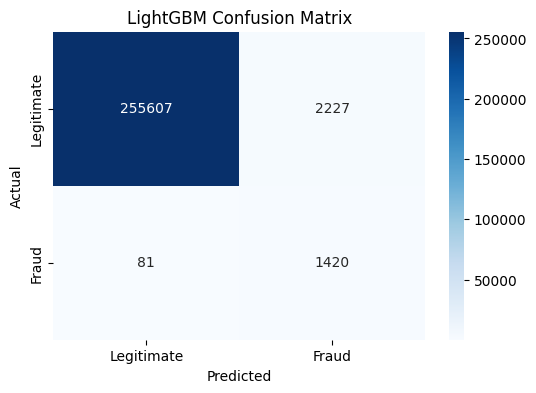


XGBoost Performance:
Accuracy: 0.9197
Precision: 0.0670
Recall: 0.9960
F1 Score: 0.1256
MCC: 0.2477
ROC-AUC: 0.9971
PR-AUC: 0.8637


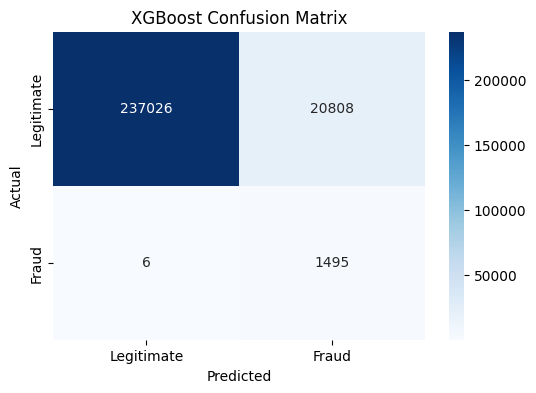


Voting (LGBM+XGB) Performance:
Accuracy: 0.9737
Precision: 0.1789
Recall: 0.9860
F1 Score: 0.3029
MCC: 0.4143
ROC-AUC: 0.9977
PR-AUC: 0.8874


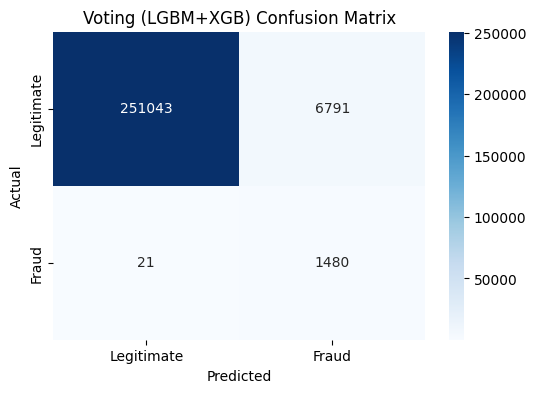


Stacking (LGBM+XGB) Performance:
Accuracy: 0.9792
Precision: 0.2151
Recall: 0.9813
F1 Score: 0.3528
MCC: 0.4544
ROC-AUC: 0.9978
PR-AUC: 0.8873


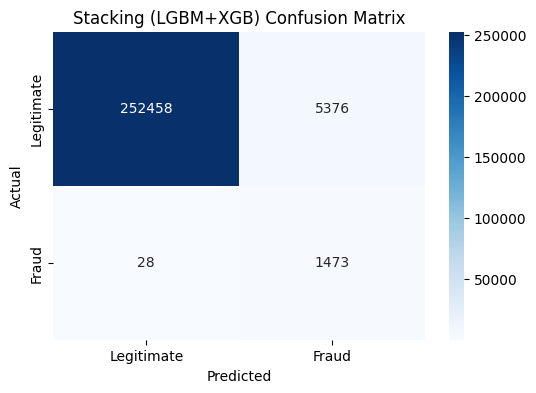


Blending (LGBM+XGB) Performance:
Accuracy: 0.9825
Precision: 0.2461
Recall: 0.9780
F1 Score: 0.3932
MCC: 0.4860
ROC-AUC: 0.9978
PR-AUC: 0.8870


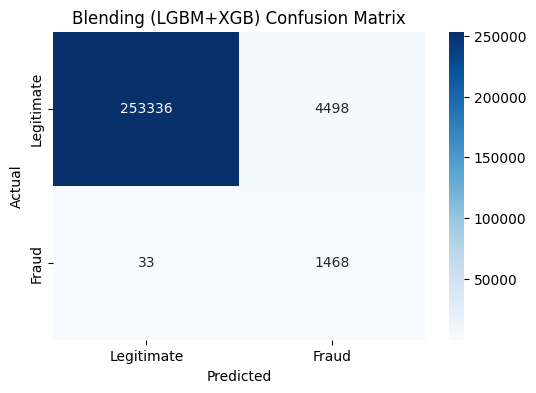


Summary of Results:
              Model  Accuracy  Precision   Recall       F1      MCC  ROC-AUC   PR-AUC
           LightGBM  0.991100   0.389361 0.946036 0.551671 0.603895 0.997739 0.878743
            XGBoost  0.919741   0.067031 0.996003 0.125609 0.247650 0.997054 0.863658
  Voting (LGBM+XGB)  0.973733   0.178938 0.986009 0.302906 0.414297 0.997736 0.887391
Stacking (LGBM+XGB)  0.979162   0.215068 0.981346 0.352814 0.454384 0.997755 0.887276
Blending (LGBM+XGB)  0.982528   0.246061 0.978015 0.393197 0.486039 0.997786 0.886956


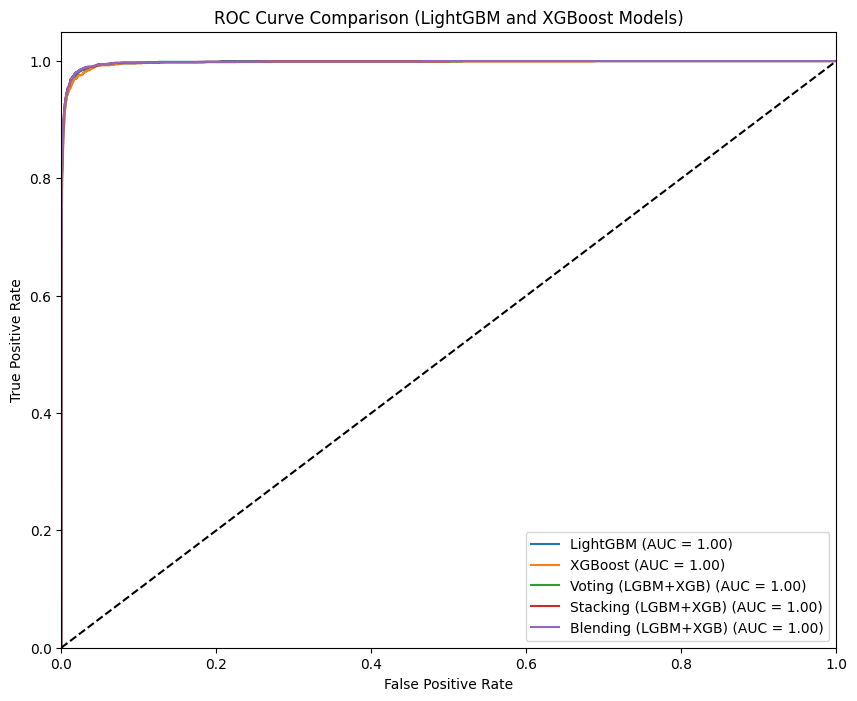

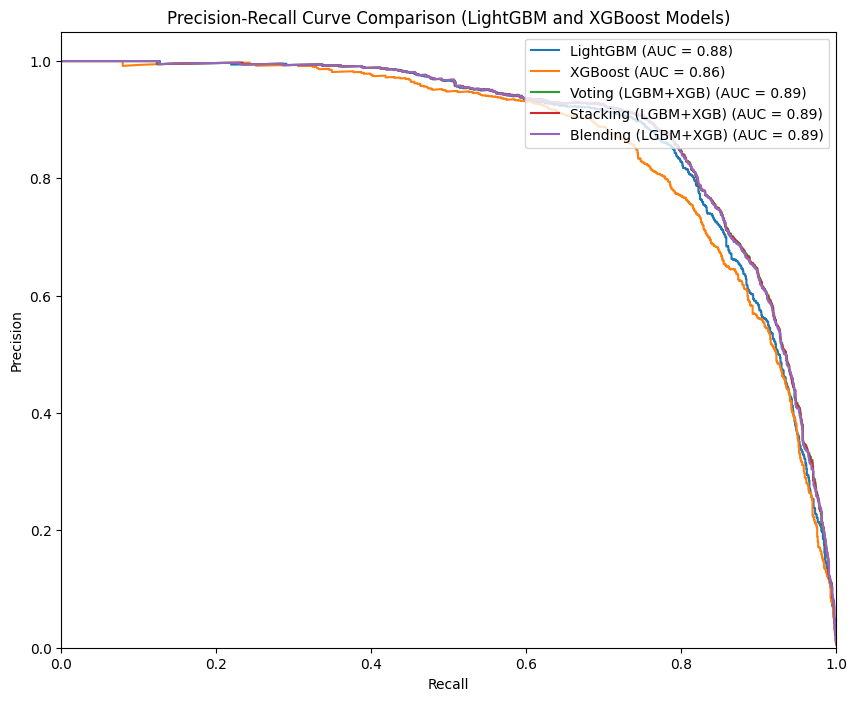

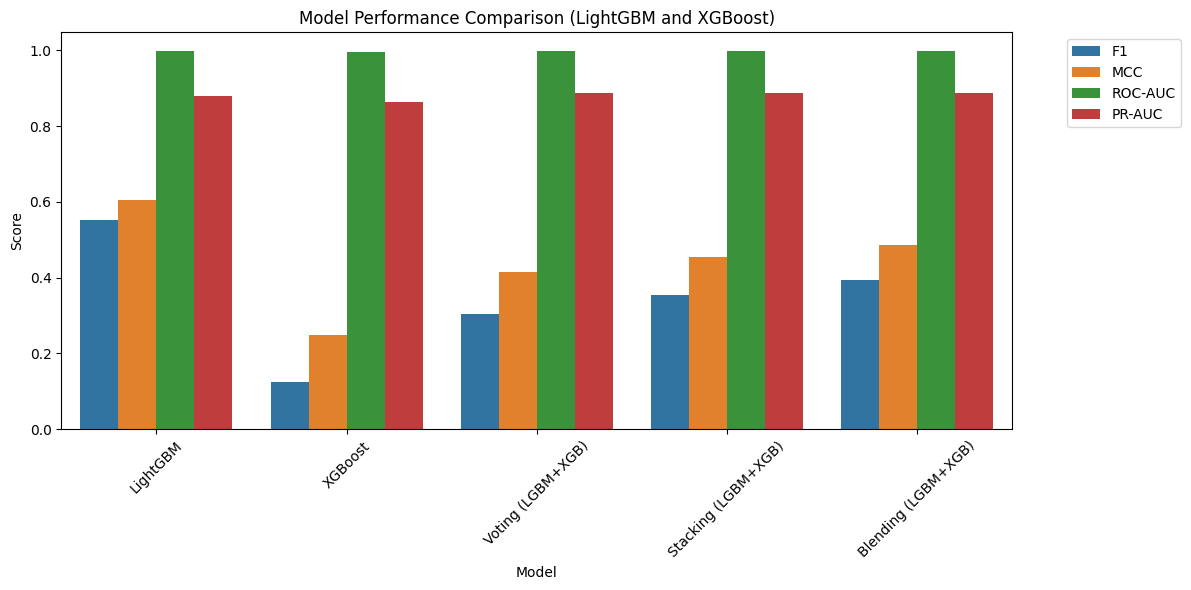


Best Model Evaluation:
Model Name: LightGBM
Combined Score: 0.6893
F1 Score: 0.5517
MCC: 0.6039
Recall: 0.9460
Precision: 0.3894
ROC-AUC: 0.9977
PR-AUC: 0.8787

LightGBM Feature Importance:
                   Feature  Importance
2         transaction_hour         505
0                      amt         421
9           user_txn_count         263
1               amount_log         187
4          transaction_dow         166
15    category_food_dining         150
6      time_since_last_txn         138
13                     age         112
7       merchant_txn_count         104
10    amount_diff_from_avg          91
23       category_misc_pos          87
5        transaction_month          80
16  category_gas_transport          71
14  category_entertainment          61
20           category_home          57
21      category_kids_pets          55
24  category_personal_care          49
18    category_grocery_pos          46
8          user_avg_amount          46
17    category_grocery_net   

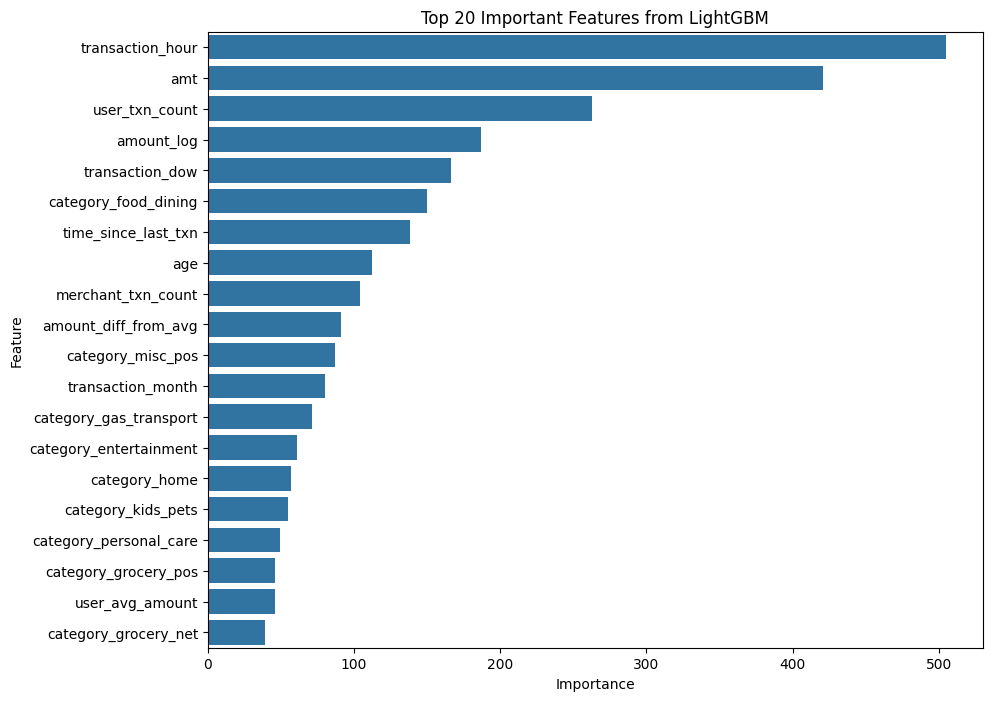


Results saved to fraud_detection_results_lgbm_xgb_smote.csv


In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                           f1_score, matthews_corrcoef, roc_auc_score,
                           precision_recall_curve, auc, confusion_matrix,
                           roc_curve)
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Load the dataset
try:
    df = pd.read_csv('credit_card_transactions.csv')
    print("Dataset loaded successfully with shape:", df.shape)
except FileNotFoundError:
    print("Please download the dataset and update the file path")
    exit()

# Display basic info
print("\nDataset Info:")
print(df.info())
print("\nFirst 5 rows:")
print(df.head())

## Data Preprocessing
def preprocess_data(df):
    # Convert timestamp to datetime and extract features
    df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'])
    df['transaction_hour'] = df['trans_date_trans_time'].dt.hour
    df['transaction_day'] = df['trans_date_trans_time'].dt.day
    df['transaction_dow'] = df['trans_date_trans_time'].dt.dayofweek
    df['transaction_month'] = df['trans_date_trans_time'].dt.month

    # Time since last transaction per credit card
    df = df.sort_values(['cc_num', 'trans_date_trans_time'])
    df['time_since_last_txn'] = df.groupby('cc_num')['trans_date_trans_time'].diff().dt.total_seconds()

    # Transaction amount features
    df['amount_log'] = np.log1p(df['amt'])

    # Merchant features
    df['merchant_txn_count'] = df.groupby('merchant')['trans_num'].transform('count')

    # User behavioral features
    df['user_avg_amount'] = df.groupby('cc_num')['amt'].transform('mean')
    df['user_txn_count'] = df.groupby('cc_num')['trans_num'].transform('count')
    df['amount_diff_from_avg'] = df['amt'] - df['user_avg_amount']

    # Location features
    df['distance_from_home'] = np.sqrt(
        (df['merch_lat'] - df['lat'])**2 +
        (df['merch_long'] - df['long'])**2
    )

    # Age feature from dob
    df['dob'] = pd.to_datetime(df['dob'])
    df['age'] = (pd.to_datetime('today') - df['dob']).dt.days // 365

    # Drop columns that won't be used
    cols_to_drop = ['Unnamed: 0', 'trans_date_trans_time', 'trans_num', 'unix_time',
                   'first', 'last', 'street', 'dob', 'job', 'merch_zipcode']
    cols_to_drop = [col for col in cols_to_drop if col in df.columns]
    df = df.drop(cols_to_drop, axis=1)

    return df

print("\nPreprocessing data...")
df = preprocess_data(df)

# Handle missing values
print("\nMissing values before handling:")
print(df.isnull().sum())

# Fill missing values
df['time_since_last_txn'].fillna(df['time_since_last_txn'].median(), inplace=True)

print("\nMissing values after handling:")
print(df.isnull().sum())

# Encode categorical variables
cat_cols = ['merchant', 'category', 'gender', 'city', 'state', 'zip']

# For memory efficiency, downcast numeric columns
num_cols = [col for col in df.columns if col not in cat_cols + ['is_fraud']]
for col in num_cols:
    if df[col].dtype == 'float64':
        df[col] = pd.to_numeric(df[col], downcast='float')
    elif df[col].dtype == 'int64':
        df[col] = pd.to_numeric(df[col], downcast='integer')

# Check class balance
fraud_ratio = df['is_fraud'].mean()
print(f"\nFraud ratio: {fraud_ratio:.4f} ({fraud_ratio*100:.2f}%)")

## Feature Engineering and Selection
features = [
    'amt', 'amount_log', 'transaction_hour', 'transaction_day',
    'transaction_dow', 'transaction_month', 'time_since_last_txn',
    'merchant_txn_count', 'user_avg_amount', 'user_txn_count',
    'amount_diff_from_avg', 'distance_from_home', 'city_pop', 'age',
    'category', 'gender', 'state'
]

# Separate features and target
X = df[features]
y = df['is_fraud']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Preprocessing pipeline
numeric_features = [col for col in features if col not in ['category', 'gender', 'state']]
categorical_features = ['category', 'gender', 'state']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# Use SMOTE for handling class imbalance
smote = SMOTE(sampling_strategy=0.5, random_state=42)  # We'll generate samples until minority is half of majority

## Model Definitions - LightGBM and XGBoost only

# LightGBM
lgbm_params = {
    'objective': 'binary',
    'metric': 'auc',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1,
    'random_state': 42,
    'class_weight': 'balanced'
}

lgbm_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('sampling', smote),  # Changed from under to smote
    ('classifier', LGBMClassifier(**lgbm_params))
])

# XGBoost
xgb_params = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'learning_rate': 0.1,
    'max_depth': 6,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'scale_pos_weight': 1/fraud_ratio,
    'random_state': 42,
    'n_jobs': -1
}

xgb_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('sampling', smote),  # Changed from under to smote
    ('classifier', XGBClassifier(**xgb_params))
])

## Combination Models - Only LightGBM + XGBoost

# 1. Voting Classifier
voting_lgbm_xgb = VotingClassifier(
    estimators=[
        ('lgbm', lgbm_pipe),
        ('xgb', xgb_pipe)
    ],
    voting='soft'
)

# 2. Stacking Classifier
stacking_lgbm_xgb = StackingClassifier(
    estimators=[
        ('lgbm', lgbm_pipe),
        ('xgb', xgb_pipe)
    ],
    final_estimator=LogisticRegression(class_weight='balanced'),
    cv=5,
    n_jobs=-1
)

# 3. Custom Blending Model
class BlendingClassifier:
    def __init__(self, models, weights=None):
        self.models = models
        self.weights = weights if weights else [1/len(models)]*len(models)

    def fit(self, X, y):
        for model in self.models:
            model.fit(X, y)
        return self

    def predict_proba(self, X):
        probas = [model.predict_proba(X)[:, 1] for model in self.models]
        weighted_probas = np.average(np.array(probas), axis=0, weights=self.weights)
        return np.vstack([1-weighted_probas, weighted_probas]).T

    def predict(self, X, threshold=0.5):
        return (self.predict_proba(X)[:, 1] > threshold).astype(int)

blend_lgbm_xgb = BlendingClassifier(
    models=[lgbm_pipe, xgb_pipe],
    weights=[0.6, 0.4]  # Slightly favor LightGBM
)

## Model Training
models = {
    'LightGBM': lgbm_pipe,
    'XGBoost': xgb_pipe,
    'Voting (LGBM+XGB)': voting_lgbm_xgb,
    'Stacking (LGBM+XGB)': stacking_lgbm_xgb,
    'Blending (LGBM+XGB)': blend_lgbm_xgb
}

print("\nTraining models...")
for name, model in models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train, y_train)

## Evaluation Functions
def evaluate_model_with_plots(model, X_test, y_test, model_name='Model'):
    try:
        y_pred_proba = model.predict_proba(X_test)[:, 1]
    except:
        # For blending classifier
        y_pred_proba = model.predict_proba(X_test)[:, 1]
    y_pred = (y_pred_proba > 0.5).astype(int)

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    mcc = matthews_corrcoef(y_test, y_pred)

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    # Precision-Recall Curve
    precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_pred_proba)
    pr_auc = auc(recall_curve, precision_curve)

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    print(f"\n{model_name} Performance:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"MCC: {mcc:.4f}")
    print(f"ROC-AUC: {roc_auc:.4f}")
    print(f"PR-AUC: {pr_auc:.4f}")

    return {
        'Model': model_name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1': f1,
        'MCC': mcc,
        'ROC-AUC': roc_auc,
        'PR-AUC': pr_auc,
        'fpr': fpr,
        'tpr': tpr,
        'precision_curve': precision_curve,
        'recall_curve': recall_curve,
        'y_pred_proba': y_pred_proba,
        'cm': cm
    }

# Evaluate all models and store results with curves
results = []
curve_data = {}

for name, model in models.items():
    result = evaluate_model_with_plots(model, X_test, y_test, name)
    results.append(result)
    curve_data[name] = {
        'fpr': result['fpr'],
        'tpr': result['tpr'],
        'precision': result['precision_curve'],
        'recall': result['recall_curve'],
        'auc': result['ROC-AUC'],
        'pr_auc': result['PR-AUC']
    }

    # Plot individual confusion matrix
    plt.figure(figsize=(6, 4))
    sns.heatmap(result['cm'], annot=True, fmt='d', cmap='Blues',
                xticklabels=['Legitimate', 'Fraud'],
                yticklabels=['Legitimate', 'Fraud'])
    plt.title(f'{name} Confusion Matrix')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

# Create results dataframe
results_df = pd.DataFrame([{k: v for k, v in r.items() if k not in ['fpr', 'tpr', 'precision_curve', 'recall_curve', 'y_pred_proba', 'cm']}
                          for r in results])
print("\nSummary of Results:")
print(results_df.to_string(index=False))

## Comparative Visualizations

# 1. ROC Curve Comparison
plt.figure(figsize=(10, 8))
for name, data in curve_data.items():
    plt.plot(data['fpr'], data['tpr'],
             label=f'{name} (AUC = {data["auc"]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison (LightGBM and XGBoost Models)')
plt.legend(loc="lower right")
plt.show()

# 2. Precision-Recall Curve Comparison
plt.figure(figsize=(10, 8))
for name, data in curve_data.items():
    plt.plot(data['recall'], data['precision'],
             label=f'{name} (AUC = {data["pr_auc"]:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve Comparison (LightGBM and XGBoost Models)')
plt.legend(loc="upper right")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.show()

# 3. Metrics Comparison Bar Plot
metrics_df = results_df.melt(id_vars=['Model'],
                            value_vars=['F1', 'MCC', 'ROC-AUC', 'PR-AUC'],
                            var_name='Metric',
                            value_name='Score')

plt.figure(figsize=(12, 6))
sns.barplot(x='Model', y='Score', hue='Metric', data=metrics_df)
plt.title('Model Performance Comparison (LightGBM and XGBoost)')
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

## Best Model Selection
results_df['Combined_Score'] = (0.4 * results_df['F1'] +
                               0.3 * results_df['MCC'] +
                               0.2 * results_df['ROC-AUC'] +
                               0.1 * results_df['PR-AUC'])

best_model_info = results_df.loc[results_df['Combined_Score'].idxmax()]
best_model_name = best_model_info['Model']

print("\n" + "="*50)
print("Best Model Evaluation:")
print("="*50)
print(f"Model Name: {best_model_name}")
print(f"Combined Score: {best_model_info['Combined_Score']:.4f}")
print(f"F1 Score: {best_model_info['F1']:.4f}")
print(f"MCC: {best_model_info['MCC']:.4f}")
print(f"Recall: {best_model_info['Recall']:.4f}")
print(f"Precision: {best_model_info['Precision']:.4f}")
print(f"ROC-AUC: {best_model_info['ROC-AUC']:.4f}")
print(f"PR-AUC: {best_model_info['PR-AUC']:.4f}")
print("="*50)

# Feature Importance visualization
if best_model_name == 'LightGBM':
    print("\nLightGBM Feature Importance:")
    lgbm_importance = pd.DataFrame({
        'Feature': numeric_features + \
                   list(lgbm_pipe.named_steps['preprocessor'].named_transformers_['cat'] \
                       .get_feature_names_out(categorical_features)),
        'Importance': lgbm_pipe.named_steps['classifier'].feature_importances_
    }).sort_values('Importance', ascending=False)

    print(lgbm_importance.head(20))

    plt.figure(figsize=(10, 8))
    sns.barplot(x='Importance', y='Feature', data=lgbm_importance.head(20))
    plt.title('Top 20 Important Features from LightGBM')
    plt.show()

elif best_model_name == 'XGBoost':
    print("\nXGBoost Feature Importance:")
    xgb_importance = pd.DataFrame({
        'Feature': numeric_features + \
                   list(xgb_pipe.named_steps['preprocessor'].named_transformers_['cat'] \
                       .get_feature_names_out(categorical_features)),
        'Importance': xgb_pipe.named_steps['classifier'].feature_importances_
    }).sort_values('Importance', ascending=False)

    print(xgb_importance.head(20))

    plt.figure(figsize=(10, 8))
    sns.barplot(x='Importance', y='Feature', data=xgb_importance.head(20))
    plt.title('Top 20 Important Features from XGBoost')
    plt.show()

elif 'Stacking' in best_model_name:
    # Show stacking coefficients
    print("\nStacking Model Coefficients:")
    best_model = models[best_model_name]
    coefs = best_model.final_estimator_.coef_[0]
    for (name, _), coef in zip(best_model.estimators, coefs):
        print(f"{name}: {coef:.4f}")

    plt.figure(figsize=(8, 4))
    sns.barplot(x=[name for name, _ in best_model.estimators], y=coefs)
    plt.title('Stacking Model Weights')
    plt.ylabel('Coefficient')
    plt.show()

# Save results
results_df.to_csv('fraud_detection_results_lgbm_xgb_smote.csv', index=False)
print("\nResults saved to fraud_detection_results_lgbm_xgb_smote.csv")